In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('/kaggle/input/fake-news/FakeNewsNet.csv')

In [3]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
def print_unique_values(col):
    print(f"{col} number of unique values => {df[col].nunique()}")

In [5]:
for col in df.columns:
    print_unique_values(col)

title number of unique values => 21724
news_url number of unique values => 21658
source_domain number of unique values => 2441
tweet_num number of unique values => 825
real number of unique values => 2


In [6]:
# Checking for unique values

df[df['title'].duplicated()]

,title,news_url,source_domain,tweet_num,real
228,Gwen Stefani Got Dumped by Blake Shelton Over ...,www.intouchweekly.com/posts/gwen-stefani-dumpe...,www.intouchweekly.com,40,0
449,Why Nikki Bella Hid Her First Marriage from Jo...,https://people.com/tv/why-nikki-bella-hid-her-...,people.com,2,1
467,Connecting People Through News,www.pressreader.com/usa/in-touch-usa/20170714/...,www.pressreader.com,1020,0
564,Connecting People Through News,www.pressreader.com/australia/womans-day-austr...,www.pressreader.com,1022,0
700,Royal baby: Prince William and Duchess Kate's ...,https://www.usatoday.com/story/life/people/201...,www.usatoday.com,48,1
...,...,...,...,...,...
23104,From Cutting Out Dairy to Mixing Up Workouts: ...,people.com/health/khloe-kardashian-fitness-die...,people.com,241,0
23148,Is Maroon 5 playing the Super Bowl halftime sh...,https://www.tennessean.com/story/news/2018/09/...,www.tennessean.com,51,1
23182,Fixer Upper Is Ending. What Is Chip and Joanna...,http://time.com/money/4958068/chip-joanna-gain...,time.com,47,1
23185,Eric Decker and Jessie James Decker Welcome So...,https://people.com/parents/eric-jessie-james-d...,people.com,23,1


In [7]:
# dropping duplicates

df.drop_duplicates(subset='title', keep='last', inplace=True)

In [8]:
df['title'].duplicated().sum()

0

In [9]:
# Checking the structure of a news url

df['news_url'][0]

'http://toofab.com/2017/05/08/real-housewives-atlanta-kandi-burruss-rape-phaedra-parks-porsha-williams/'

In [10]:
# Random exploration of the data

df.sample(n=200, random_state=12)[['title', 'news_url', 'real']].iloc[32]

title       Fifth Harmony ” Set T o Split ” 
news_url                                 NaN
real                                       0
Name: 12281, dtype: object

In [11]:
df.sample(n=200, random_state=12)[['title', 'news_url', 'real']].iloc[12]

title       ‘There is no moral’: Stephen Colbert says Trum...
news_url    https://www.japantimes.co.jp/culture/2018/12/2...
real                                                        1
Name: 19779, dtype: object

In [12]:
# Checking for null values

df.isnull().sum() / len(df)

title            0.000000
news_url         0.015006
source_domain    0.015006
tweet_num        0.000000
real             0.000000
dtype: float64

In [13]:
# dropping null values

df.dropna(inplace=True)

In [14]:
df.shape

(21398, 5)

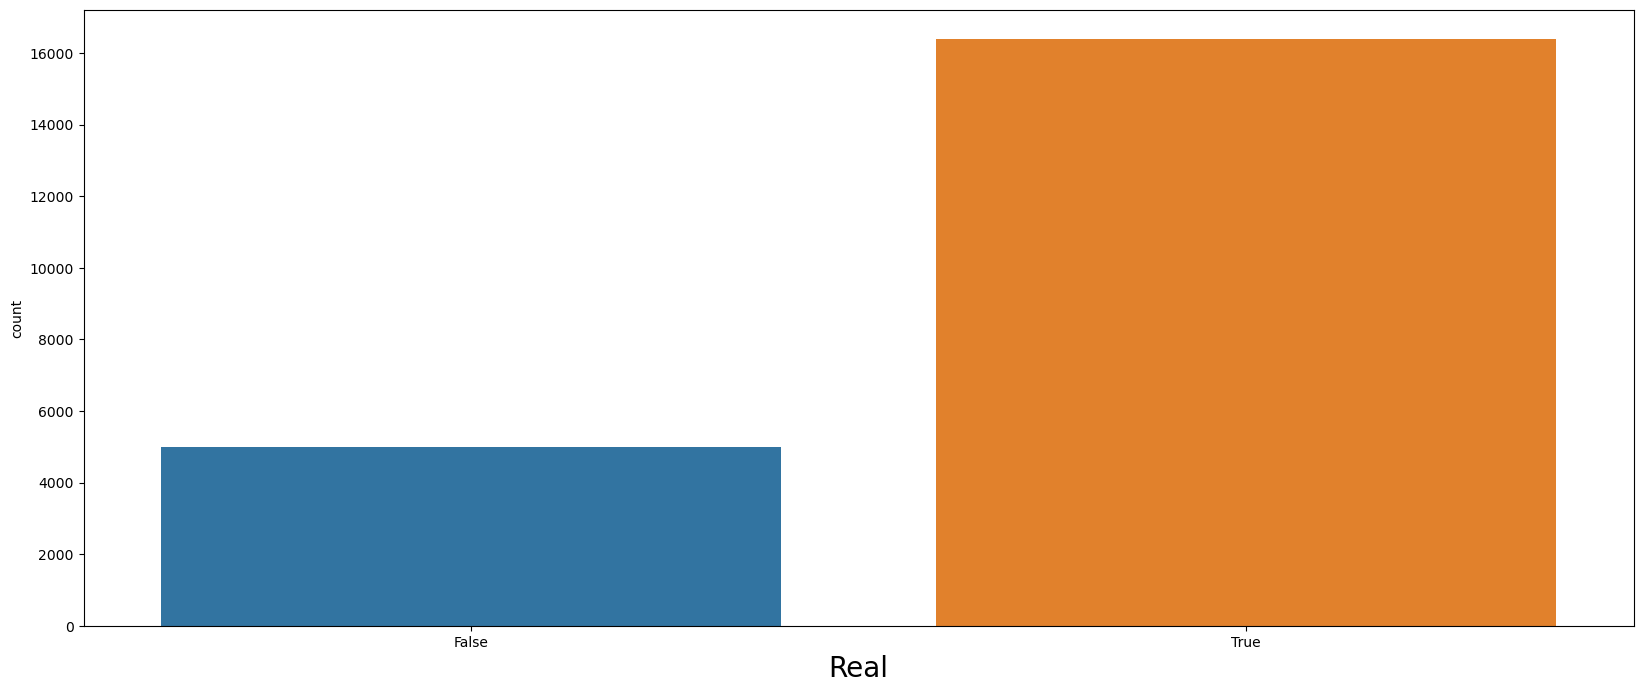

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(data=df, x='real', ax=ax)
plt.xticks([0,1], ['False', 'True'])
plt.xlabel('Real', fontsize=20)
plt.show()

In [16]:
# Extracting the needed features

def extract_source(x):
    found_match = re.search(r'(www)?(\w+\.com)', x)
    if found_match:
        return found_match.group(2)
    else:
        return 'None'

In [17]:
df['source'] = df['source_domain'].apply(extract_source)

In [18]:
# dropping news_url and source_domain

df.drop(['news_url', 'source_domain'], axis=1, inplace=True)

In [19]:
df.head()

,title,tweet_num,real,source
0,Kandi Burruss Explodes Over Rape Accusation on...,42,1,toofab.com
2,Sophia Bush Sends Sweet Birthday Message to 'O...,63,1,etonline.com
3,Colombian singer Maluma sparks rumours of inap...,20,1,None
4,Gossip Girl 10 Years Later: How Upper East Sid...,38,1,zerchoo.com
6,Broward County Sheriff Fired For Lying About P...,124,0,yournewswire.com


In [20]:
df.title.sample(n=30, random_state=10).loc[974]

"Katie Holmes and Jamie Foxx 'split' after five year secret romance"

In [21]:
def clean_text(text):
    rgx = r"[^A-Za-z0-9\s\.]"
    return re.sub(rgx, '', text)

In [22]:
word_tokenize(clean_text(df.title.sample(n=30, random_state=10).loc[974]))

['Katie',
 'Holmes',
 'and',
 'Jamie',
 'Foxx',
 'split',
 'after',
 'five',
 'year',
 'secret',
 'romance']

In [23]:
# Creating a set of all possible stop words 

STOP_WORDS = ENGLISH_STOP_WORDS.union(stopwords.words('english')).union(STOPWORDS)

In [24]:
def remove_stop_words(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return ' '.join(tokens)

In [25]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text): 
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [26]:
def preprocess_text(text):
    text = text.lower()
    preprocessed_text = lemmatize_text(remove_stop_words(clean_text(text)))
    return preprocessed_text

In [27]:
preprocess_text(df.title.sample(n=30, random_state=10).loc[974])

'katie holmes jamie foxx split year secret romance'

In [28]:
df['title'] = df['title'].apply(preprocess_text)

In [29]:
df.head()

,title,tweet_num,real,source
0,kandi burruss explodes rape accusation real ho...,42,1,toofab.com
2,sophia bush sends sweet birthday message tree ...,63,1,etonline.com
3,colombian singer maluma spark rumour inappropr...,20,1,None
4,gossip girl 10 year later upper east siders sh...,38,1,zerchoo.com
6,broward county sheriff fired lying parkland,124,0,yournewswire.com


In [30]:
df.reset_index(drop=True, inplace=True)

In [31]:
X = df.drop('real', axis=1)
y = df['real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
X_train.head()

,title,tweet_num,source
14264,bts get pelted fruit late late,3,14.com
14317,trump vote death penalty gay,550,None
18981,rumor review denzel washington support trump f...,7,None
3251,jenelle evans wedding dress teen mom 2 star dr...,1,intouchweekly.com
13273,janet jackson call police welfare check son st...,69,cbsnews.com


In [33]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

tf = TfidfVectorizer()
tf_title = tf.fit_transform(X_train['title'])

X_train_title = pd.DataFrame(data=tf_title.toarray(), columns=tf.get_feature_names())
X_source_dummies = pd.get_dummies(X_train['source'], drop_first=True)

new_X_train = pd.concat([X_train_title, X_source_dummies], axis=1)
print(new_X_train.shape)

(17118, 17073)


In [34]:
tf_test_title = tf.transform(X_test['title'])
X_test_title = pd.DataFrame(data=tf_test_title.toarray(), columns=tf.get_feature_names())

X_source_dummies = pd.get_dummies(X_test['source'], drop_first=True)

new_X_test = pd.concat([X_test_title, X_source_dummies], axis=1)
print(new_X_test.shape)

(4280, 16275)


In [35]:
new_X_test = new_X_test.reindex(columns=new_X_train.columns, fill_value=0)

In [36]:
log_reg = LogisticRegression(C=5)
log_reg.fit(new_X_train, y_train)
log_preds = log_reg.predict(new_X_test)
print(f"test score {log_reg.score(new_X_test, y_test)}")
print(f"train score {log_reg.score(new_X_train, y_train)}")

test score 0.8633177570093458
train score 0.9437434279705573


In [37]:
def print_classification_report(y_test, y_pred, model_name):
    print(f"{model_name.capitalize()} Classification Report")
    print("*"*30)
    print(classification_report(y_test, y_pred))
    print("*"*30)
    
def print_confusion_matrix(y_test, y_pred, model_name):
    print(f"{model_name.capitalize()} Confusion Matrix")
    print("*"*30)
    print(confusion_matrix(y_test, y_pred))
    print("*"*30) 

In [38]:
print_classification_report(y_test, log_preds, 'Logistic Regression')

Logistic regression Classification Report
******************************
              precision    recall  f1-score   support

           0       0.79      0.57      0.66      1001
           1       0.88      0.95      0.91      3279

    accuracy                           0.86      4280
   macro avg       0.83      0.76      0.79      4280
weighted avg       0.86      0.86      0.85      4280

******************************


In [39]:
xgb = XGBClassifier()
xgb.fit(new_X_train, y_train)
xgb_preds = xgb.predict(new_X_test)
print(f"test score {xgb.score(new_X_test, y_test)}")
print(f"train score {xgb.score(new_X_train, y_train)}")

test score 0.8544392523364486
train score 0.882229232386961


In [40]:
print_classification_report(y_test, xgb_preds, 'XGB')

Xgb Classification Report
******************************
              precision    recall  f1-score   support

           0       0.84      0.47      0.60      1001
           1       0.86      0.97      0.91      3279

    accuracy                           0.85      4280
   macro avg       0.85      0.72      0.76      4280
weighted avg       0.85      0.85      0.84      4280

******************************


In [41]:
rfc = RandomForestClassifier(max_depth=100, n_estimators=50)
rfc.fit(new_X_train, y_train)
rfc_preds = rfc.predict(new_X_test)
print(f"test score {rfc.score(new_X_test, y_test)}")
print(f"train score {rfc.score(new_X_train, y_train)}")

test score 0.8453271028037384
train score 0.9070568991704638


In [42]:
cat = CatBoostClassifier(verbose=False)
cat.fit(new_X_train, y_train)
cat_preds = cat.predict(new_X_test)
print(f"test score {cat.score(new_X_test, y_test)}")
print(f"train score {cat.score(new_X_train, y_train)}")

test score 0.8544392523364486
train score 0.8755695758850333


In [43]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=100)
dtc.fit(new_X_train, y_train)
dtc_preds = dtc.predict(new_X_test)
print(f"test score {dtc.score(new_X_test, y_test)}")
print(f"train score {dtc.score(new_X_train, y_train)}")

test score 0.8301401869158879
train score 0.9575300852903377
